In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 10: Clustering Analysis in Python
Nov 7, 2019

## Housekeeping

- Assignment #6 due next week
- Last HW + final project description due in 3 weeks (Nov 26)

## Recap

- Last week: urban street networks + interactive web maps
- New tools: OSMnx, Pandana, and Folium
- Solutions to in-class exercises have been posted

## Today: Clustering

- Both spatial and non-spatial datasets
- Two new techniques: 
    - Non-spatial: **K-means**
    - Spatial: **DBSCAN**
- Two labs/exercises today:
    1. Grouping Philadelphia neighborhoods by AirBnb listings
    1. Identifying clusters in taxi rides in NYC

## Machine learning

<img src="imgs/machine_learning.jpg" width=700>

- The computer **learns** patterns and properties of an input data set without the user specifying them beforehand
- Can be both **supervised** and **unsupervised**

#### Supervised
- Example: classification
- Given a training set of **labeled** data, learn to assign labels to new data

#### Unsupervised
- Example: clustering
- Identify structure / clusters in data without any prior knowledge

## Machine learning in Python: scikit-learn

- State-of-the-art machine learning in Python
- Easy to use, lots of functionality

## Clustering is just one (of many) features
<img src="imgs/scikit_learn.png" width=700>

https://scikit-learn.org/stable/
    
**Note:** We will focus on clustering algorithms today and discuss a few other machine learning techniques in the next two weeks. If there is a specific scikit-learn use case we won't cover, I'm open to ideas for incorporating it as part of the final project. 

## Part 1: Non-spatial clustering

**The goal**

Partition a dataset into groups that have a similar set of attributes, **or features**, within the group and a dissimilar set of features between groups

## Some intuition
<img src="imgs/clustering.png" width=700>

## K-Means clustering

- Simple but robust clustering algorithm
- Widely used
- **Important:** user must specify the number of clusters
- **Cannot** be used to find density-based clusters

## This is just one of several clustering methods

https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods

## A good introduction

[Andrew Ng's Coursera lecture](https://www.youtube.com/watch?v=hDmNF9JG3lo&feature=youtu.be)

## How does it work?

**Minimizes the intra-cluster variance**: minimizes the sum of the squared distances between all points in a cluster and the cluster centroid

## K-means in action

<img src="imgs/K-means_convergence.gif" width=500>

## Example: clustering countries by health and income

- Health expectancy in years vs. GDP per capita and population for 187 countries (as of 2015)
- Data from [Gapminder](https://www.gapminder.org/data/)

In [3]:
import altair as alt
from vega_datasets import data
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

Read the data from a URL:

In [4]:
gapminder = pd.read_csv(data.gapminder_health_income.url)
gapminder.head()

,country,income,health,population
0,Afghanistan,1925,57.63,32526562
1,Albania,10620,76.00,2896679
2,Algeria,13434,76.50,39666519
3,Andorra,46577,84.10,70473
4,Angola,7615,61.00,25021974


## Plot it with altair

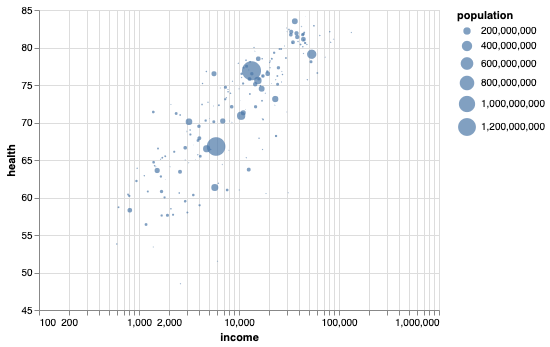

In [5]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    tooltip=list(gapminder.columns)
).interactive()

## K-Means with scikit-learn

In [6]:
from sklearn.cluster import KMeans

Let's start with 5 clusters

In [7]:
kmeans = KMeans(n_clusters=5)

Lot's of optional parameters, but `n_clusters` is the most important:

In [8]:
 kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Let's fit just income first

Use the `fit()` function

In [9]:
kmeans.fit(gapminder[['income']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Extract the cluster labels

Use the `labels_` attribute

In [10]:
gapminder['label'] = kmeans.labels_

## How big are our clusters?

In [11]:
gapminder.groupby('label').size()

label
0    106
1     24
2      6
3     50
4      1
dtype: int64

## Plot it again, coloring by our labels

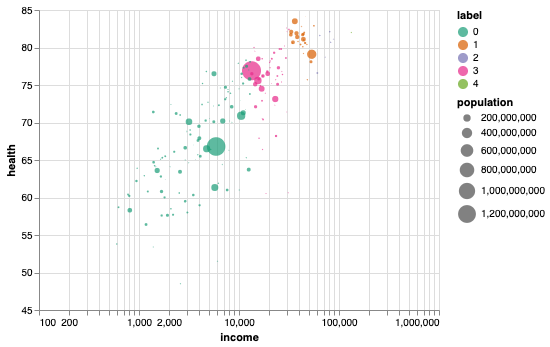

In [12]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

Data is nicely partitioned into income levels

## How about health, income, and population?

In [13]:
# fit all three columns
kmeans.fit(gapminder[['income', 'health', 'population']])

# extract the labels
gapminder['label'] = kmeans.labels_

## Plot the new labels

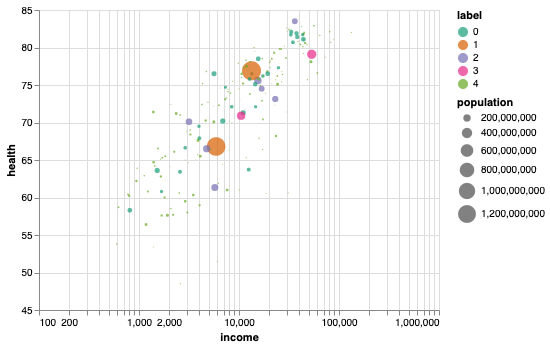

In [14]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

### It....didn't work that well

What's wrong?

**K-means is distance-based, but our features have wildly different distance scales**

## scikit-learn to the rescue: pre-processing

Scikit-learn has a utility to normalize features to the range [0,1] with variance of 1

In [8]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()

## Use the `fit_transform()` function to scale your features

In [17]:
gapminder_scaled = scaler.fit_transform(gapminder[['income', 'health', 'population']])

In [18]:
# mean of zero
gapminder_scaled.mean(axis=0)

array([ 8.07434927e-17, -1.70511258e-15, -1.89984689e-17])

In [19]:
# variance of one
gapminder_scaled.std(axis=0)

array([1., 1., 1.])

## Now fit the scaled features

In [20]:
# perform the fit
kmeans.fit(gapminder_scaled)

# extract the labels
gapminder['label'] = kmeans.labels_

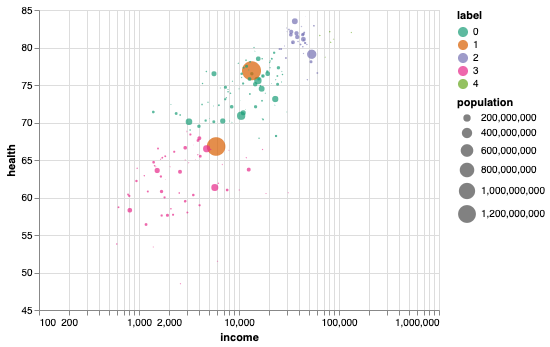

In [21]:
alt.Chart(gapminder).mark_circle().encode(
    alt.X('income:Q', scale=alt.Scale(type='log')),
    alt.Y('health:Q', scale=alt.Scale(zero=False)),
    size='population:Q',
    color=alt.Color('label:N', scale=alt.Scale(scheme='dark2')),
    tooltip=list(gapminder.columns)
).interactive()

## Exercise: clustering neighborhoods by Airbnb stats

I've extracted neighborhood Airbnb statistics for Philadelphia neighborhoods from [Tom Slee's website](http://tomslee.net/airbnb-data)

The data includes average price per person, overall satisfaction, and number of listings.

## Two good references for Airbnb data

- [Tom Slee's website](http://tomslee.net/airbnb-data)
- [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

## Step 1: load the data

In [2]:
airbnb = pd.read_csv("data/philly_airbnb_by_neighborhoods.csv")
airbnb.head()

NameError: name 'pd' is not defined

## Step 2: perform the K-Means fit

- Use our three features: `price_per_person`, `overall_satisfaction`, `N`
- I used 5 clusters, but you are welcome to experiment with different values!
- Scaling the features is recommended, but if the scales aren't too different, so probably isn't necessary in this case

## Step 3: calculate average features per cluster

To gain some insight into our clusters, after calculating the K-Means labels:
- group by the `label` column
- calculate the `mean()` of each of our features
- calculate the number of neighborhoods per cluster

## Step 4: plot a choropleth, coloring neighborhoods by their cluster label

- Part 1: Load the Philadelphia neighborhoods available in the data directory:  
    - `./data/philly_neighborhoods.geojson`
- Part 2: Merge the Airbnb data (with labels) and the neighborhood polygons
- Part 3: Use geopandas to plot the neighborhoods
    - The `categorical=True` and `legend=True` keywords will be useful here

## Step 5: Plot an interactive map

Use altair to plot the clustering results with a tooltip for neighborhood name and tooltip.

**Hint:** See week 4's lecture on interactive choropleth's with altair

## Based on these results, where would you want to stay?

## Part 2: Spatial clustering

Now on to the more traditional view of "clustering"...

## DBSCAN

"Density-Based Spatial Clustering of Applications with Noise"

- Clusters are areas of **high density** separated by areas of low density.
- Can identify clusters of any shape
- Good at separating **core samples** in high-density regions from low-density **noise** samples
- **Best for spatial data**

## Two key parameters 

1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
1. **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point.

## Importance of parameter choices

Higher `min_samples` or a lower `eps` requires a higher density necessary to form a cluster.

## Example: OpenStreetMap GPS traces in Philadelphia

Data extracted from the set of 1 billion GPS traces from OSM

In [41]:
coords = gpd.read_file('./data/osm_gps_philadelphia.geojson')
coords.head()

,x,y,geometry
0,-8370750.5,4865303.0,POINT (-8370750.500 4865303.000)
1,-8368298.0,4859096.5,POINT (-8368298.000 4859096.500)
2,-8365991.0,4860380.0,POINT (-8365991.000 4860380.000)
3,-8372306.5,4868231.0,POINT (-8372306.500 4868231.000)
4,-8376768.5,4864341.0,POINT (-8376768.500 4864341.000)


In [42]:
len(coords)

52358

## DBSCAN basics

In [14]:
from sklearn.cluster import dbscan 

In [44]:
# some parameters to start with
eps = 50  # in meters
min_samples = 100

cores, labels = dbscan(coords[["x", "y"]], eps=eps, min_samples=min_samples)

The function returns two objects, which we call `cores` and `labels`. `cores` contains the indices of each point which is classified as a core. 

In [45]:
# the first 5 elements
cores[:5]

array([ 4,  6, 10, 12, 16])

The length of cores tells you how many samples were grouped into *any* cluster:

In [46]:
print(len(cores))

12941


The `labels` tells you the cluster number each sample belongs to. Those points classified as noise receive a cluster number of `-1`: 

In [47]:
# the first 5 elements
labels[:5]

array([-1, -1, -1, -1,  0])

The `labels` array is the same length as our input data, so we can add it as a column in our original data frame

In [48]:
# add our labels to the original data
coords['label'] = labels

The number of clusters is the number of unique labels minus one (because noise has a label of -1)

In [49]:
num_clusters = coords['label'].nunique() - 1
print("number of clusters = ", num_clusters)

number of clusters =  30


We can group by the `label` column to get the size of each cluster:

In [50]:
coords.groupby('label').size()

label
-1     37317
 0      4070
 1      1717
 2      2690
 3       736
 4       106
 5       301
 6       525
 7       224
 8       685
 9       511
 10      268
 11      274
 12      121
 13      295
 14      168
 15      127
 16      118
 17      289
 18      150
 19      202
 20      153
 21      151
 22      194
 23      164
 24      240
 25      100
 26      111
 27      108
 28      143
 29      100
dtype: int64

## Now let's plot the noise and clusters

- Extract each cluster: select points with the same label number
- Plot the cluster centers: the mean `x` and mean `y` value for each cluster

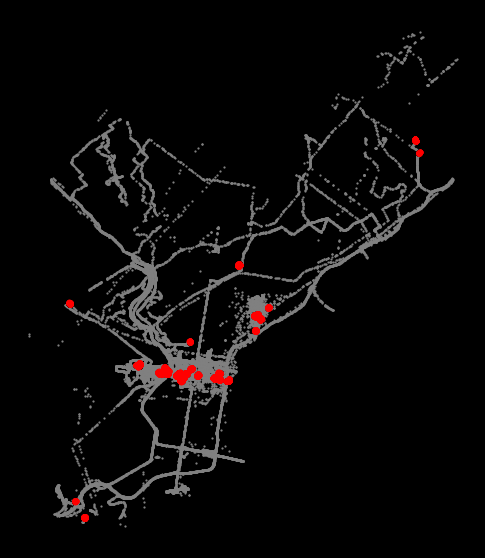

In [51]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(10, 10), facecolor='black')

# Plot the noise samples in grey
noise = coords.loc[coords['label']==-1]
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)

# loop over each cluster number
for label_num in range(num_clusters):
    
    # extract the samples with this label number
    this_cluster = coords.loc[coords['label'] == label_num]
    
    # plot the centroids
    ax.scatter(this_cluster['x'], this_cluster['y'], 
                linewidth=0, color='red')

# format and show
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

## Exercise: What happens if we change the parameters?

Test out a few different combinations of `eps` and `min_samples`

**Remember** higher `min_samples` or lower `eps` means higher density necessary to form a cluster.

## Extending DBSCAN beyond just spatial coordinates

DBSCAN can perform high-density clusters from more than just spatial coordinates, as long as they are properly normalized

## Exercise: Extracting patterns from NYC taxi rides

I've extracted data for taxi pickups or drop offs occurring in the Williamsburg neighborhood of NYC from the NYC taxi open data. 

Includes data for: 
- Pickup/dropoff location
- Fare amount
- Trip distance
- Pickup/dropoff hour

**Goal:** identify clusters of similar taxi rides that are not only clustered spatially, but also clustered for features like hour of day and trip distance

Inspired by [this CARTO blog post](https://carto.com/blog/using-location-data-identify-communities-williamsburg-ny/)

## Step 1: Load the data

In [ ]:
taxi = pd.read_csv("./data/williamsburg_taxi_trips.csv")
taxi.head()

## Step 2: Extract and normalize several features

We will focus on the following columns:
- `pickup_x` and `pickup_y`
- `dropoff_x` and `dropoff_y`
- `trip_distance`
- `pickup_hour`

Use the `StandardScaler` to normalize these features.

## Step 3: Run DBSCAN to extract high-density clusters

- We want the highest density clusters, ideally no more than about 30-50 clusters.
- Run the DBSCAN and experiment with different values of `eps` and `min_samples`
    - I started with `eps` of 0.25 and `min_samples` of 50 

- Add the labels to the original data frame and calculate the number of clusters. It should be less than 50 or so. 
    
**Hint:** If the algorithm is taking a long time to run (more than a few minutes), the `eps` is probably too big!

## Step 4: Identify the 5 largest clusters

Group by the label, calculate and sort the sizes to find the label numbers of the top 5 largest clusters

## Step 5: Get mean statistics for the top 5 largest clusters

To better identify trends in the top 5 clusters, calculate the mean trip distance and pickup_hour for each of the clusters.

## Step 6a: Visualize the top 5 largest clusters

Now visualize the top 5 largest clusters:
- plot the dropoffs and pickups (same color) for the 5 largest clusters
- include the "noise" samples, shown in gray
      

**Hints:**
- For a given cluster, plot the dropoffs and pickups with the same color so we can visualize patterns in the taxi trips
- A good color scheme for a black background is given below

## Step 6b: Visualizing one cluster at a time

Another good way to visualize the results is to explore the other clusters one at a time, plotting both the pickups and dropoffs to identify the trends.  

Use different colors for pickups/dropoffs to easily identify them.

Make it a function so we can repeat it easily:

## If you're feeling ambitious, and time-permitting...

## Step 7: an interactive map of clusters with Holoviews + Datashader

- Create two `hv.Points` objects: one each for the pickup/dropoff locations for the top 5 clusters
- Use the `datashade` function to aggregate the categorical label data
- You will need to specify a color key that maps the labels to specific colors
- Add a background tile using Geoviews
- Combine the pickups, dropoffs, and background tile into a single interactive map

**Hint:** see the example from lecture #7 that created an interactive map of demographic data from the census using Holoviews and datashader